In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import time
from DataCaller import DataCaller
from Model import Net
from EarlyStop import EarlyStopping

#use gpu    please somebody buy me a gpu .......
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

#Global variables
LOAD_DATA = True
BATCH_SIZE = 64
VAL_BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 100
PATIENCE = 20
VALIDATE_EVERY = 8
MODEL_NAME = f"model-{int(time.time())}"
IMG_SIZE = 64

cpu


In [2]:
#data path
BASE_PATH = 'big'
TRAIN_PATH_IMG = os.path.join('images', BASE_PATH, 'train')
TRAIN_PATH_LABEL = os.path.join('data', BASE_PATH, 'traindata.xlsx')
VAL_PATH_IMG = os.path.join('images', BASE_PATH, 'val')
VAL_PATH_LABEL = os.path.join('data', BASE_PATH, 'valdata.xlsx')
TEST_PATH_IMG = os.path.join('images', BASE_PATH, 'test')
TEST_PATH_LABEL = os.path.join('data', BASE_PATH, 'testdata.xlsx')
LOAD_PRETRAINED_PATH = 'checkpoint.pt'

In [3]:
#load data
if LOAD_DATA:
    trainset = DataCaller(TRAIN_PATH_IMG, TRAIN_PATH_LABEL, IMG_SIZE)
    valset = DataCaller(VAL_PATH_IMG, VAL_PATH_LABEL, IMG_SIZE)
    testset = DataCaller(TEST_PATH_IMG, TEST_PATH_LABEL, IMG_SIZE)
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

8000
1000
1000


In [4]:
#define dataloaders
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

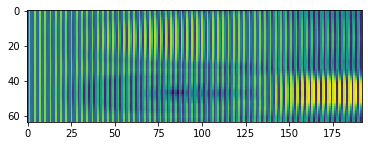

tensor([[6.8051e+00, 1.5679e+01, 6.5160e+00, 5.0531e+00, 4.1559e+00],
        [1.8210e+01, 1.9452e+01, 9.3784e+00, 9.9184e+00, 3.2224e+00],
        [1.2746e+01, 1.9351e+01, 3.4672e+00, 1.0198e+01, 4.6448e+00],
        [1.0924e+01, 7.4024e+00, 9.2469e+00, 1.2121e+00, 4.4162e+00],
        [9.5331e+00, 7.2050e+00, 2.2235e+00, 3.9912e+00, 3.9521e+00],
        [1.7879e+01, 1.8666e+01, 1.2508e+01, 1.3536e+01, 1.9195e+00],
        [1.1283e+01, 6.9068e+00, 7.3861e+00, 5.9673e+00, 2.0984e+00],
        [5.7748e+00, 1.2618e+01, 1.7380e+00, 3.0351e+00, 4.1040e+00],
        [1.4915e+01, 6.9008e+00, 8.1093e+00, 9.1378e-01, 2.6739e+00],
        [1.1380e+01, 1.6740e+01, 6.7048e+00, 7.9035e+00, 1.1352e+00],
        [1.9130e+01, 1.1801e+01, 3.6909e+00, 1.6315e+00, 2.9223e+00],
        [6.0276e+00, 8.0786e+00, 4.3617e+00, 4.6464e+00, 1.8009e+00],
        [1.1784e+01, 1.8328e+01, 5.4780e+00, 1.0726e+01, 1.0467e+00],
        [1.2774e+01, 1.4382e+01, 1.3942e+00, 2.0489e-01, 2.9736e+00],
        [1.1516e+01,

In [5]:
#just checking if the data is loaded properly
for i, data in enumerate(trainloader):
    x, y = data
    
    #print(x)
    x = np.array(x)
    x = x.reshape(IMG_SIZE, IMG_SIZE, -1)
    #print(x)
    x = x.astype(int)
    plt.imshow(x[0])
    plt.show()
    print(y)
    break

In [6]:
#train the model
def train(net, model_name, patience, validate_every):
    
    optimizer = optim.Adam(net.parameters(), LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    loss_function = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    avg_train_losses = []
    avg_val_losses = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    with open("model.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
                net.train()
                for batch_idx, samples in enumerate(trainloader):
                    x, y = samples
                    x = x.view(-1, 3, IMG_SIZE, IMG_SIZE)

                    net.zero_grad()
                    pred = net(x)
                    loss = loss_function(pred, y)
                    loss.backward()
                    optimizer.step()
                    
                    error = (pred - y) / y
                    error = error.mean(0)
                    train_losses.append(loss.item())
                    
                    #if idx%validate_every == 0:
                net.eval()
                for batch_idx, samples in enumerate(valloader):
                    val_x, val_y = samples
                    val_x = val_x.view(-1, 3, IMG_SIZE, IMG_SIZE)
                    val_pred = net(val_x)
                    val_loss = loss_function(val_pred, val_y)
                    val_error = (val_pred - val_y) / val_y
                    val_error = val_error.mean(0)
                    val_losses.append(val_loss.item())
                    
                train_loss = np.average(train_losses)
                valid_loss = np.average(val_losses)
                avg_train_losses.append(train_loss)
                avg_val_losses.append(valid_loss)
                
                train_losses = []
                val_losses = []
                
                f.write(f"{MODEL_NAME},{round(time.time(),3)},  {round(float(train_loss), 4)},  {round(float(valid_loss),4)}\n")
                print("batch : ", batch_idx)
                print("loss : ", train_loss, "\nval loss : ", valid_loss, "\n")
                print("error : ", error, "\nval error : ", val_error)
                
                early_stopping(valid_loss, net)
                
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
        # load the last checkpoint with the best model
        net.load_state_dict(torch.load('checkpoint.pt'))
        
        return avg_train_losses, avg_val_losses

In [7]:
net = Net()
train_loss, valid_loss = train(net, MODEL_NAME, PATIENCE, VALIDATE_EVERY)

  1%|▊                                                                              | 1/100 [02:25<4:00:08, 145.54s/it]

batch :  15
loss :  tensor(20.7961, grad_fn=<MseLossBackward>) 
val loss :  tensor(29.5086, grad_fn=<MseLossBackward>) 

error :  tensor([ 0.1742,  0.1805, 38.6299,  2.0531,  0.2045], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.3175, -0.2885,  0.1828,  0.2013, -0.3759], grad_fn=<MeanBackward1>)
Validation loss decreased (inf --> 29.844254).  Saving model ...


  2%|█▌                                                                             | 2/100 [04:37<3:50:55, 141.38s/it]

batch :  15
loss :  tensor(18.3966, grad_fn=<MseLossBackward>) 
val loss :  tensor(22.9820, grad_fn=<MseLossBackward>) 

error :  tensor([ 0.0754, -0.0240,  0.7095,  4.2861,  0.1353], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.2175, -0.2207,  2.2107,  1.4450, -0.2111], grad_fn=<MeanBackward1>)
Validation loss decreased (29.844254 --> 24.066813).  Saving model ...


  3%|██▎                                                                            | 3/100 [06:58<3:48:45, 141.50s/it]

batch :  15
loss :  tensor(20.4643, grad_fn=<MseLossBackward>) 
val loss :  tensor(44.1480, grad_fn=<MseLossBackward>) 

error :  tensor([-0.0116,  0.1063,  0.4607,  1.9711,  0.0104], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.4896, -0.4605, 24.0901,  2.0399, -0.3940], grad_fn=<MeanBackward1>)
EarlyStopping counter: 1 out of 20


  4%|███▏                                                                           | 4/100 [09:28<3:50:13, 143.89s/it]

batch :  15
loss :  tensor(17.5585, grad_fn=<MseLossBackward>) 
val loss :  tensor(31.5555, grad_fn=<MseLossBackward>) 

error :  tensor([0.1868, 0.1035, 2.7257, 5.3277, 0.2299], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.2556, -0.3345,  0.4779, 15.9969, -0.0902], grad_fn=<MeanBackward1>)
EarlyStopping counter: 2 out of 20


  5%|███▉                                                                           | 5/100 [11:52<3:47:41, 143.81s/it]

batch :  15
loss :  tensor(17.5297, grad_fn=<MseLossBackward>) 
val loss :  tensor(38.8036, grad_fn=<MseLossBackward>) 

error :  tensor([0.1427, 0.0479, 1.6665, 1.0926, 0.1295], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.3804, -0.4099,  0.1028,  0.5012, -0.3295], grad_fn=<MeanBackward1>)
EarlyStopping counter: 3 out of 20


  6%|████▋                                                                          | 6/100 [14:25<3:50:02, 146.84s/it]

batch :  15
loss :  tensor(16.0005, grad_fn=<MseLossBackward>) 
val loss :  tensor(27.9211, grad_fn=<MseLossBackward>) 

error :  tensor([-0.0252,  0.0120,  0.7947,  7.4480, -0.0812], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.2775, -0.2589,  1.2274,  0.3073, -0.2982], grad_fn=<MeanBackward1>)
EarlyStopping counter: 4 out of 20


  7%|█████▌                                                                         | 7/100 [16:52<3:47:26, 146.74s/it]

batch :  15
loss :  tensor(17.7336, grad_fn=<MseLossBackward>) 
val loss :  tensor(19.4371, grad_fn=<MseLossBackward>) 

error :  tensor([0.1274, 0.1231, 4.6714, 3.2188, 0.2333], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.0838, -0.1031,  1.0163,  2.5150, -0.0563], grad_fn=<MeanBackward1>)
Validation loss decreased (24.066813 --> 17.951343).  Saving model ...


  8%|██████▎                                                                        | 8/100 [19:39<3:54:26, 152.90s/it]

batch :  15
loss :  tensor(17.5348, grad_fn=<MseLossBackward>) 
val loss :  tensor(27.0333, grad_fn=<MseLossBackward>) 

error :  tensor([-0.0243,  0.0573,  0.4866,  1.8447,  0.0721], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.2998, -0.2029,  2.1688,  3.1827, -0.1046], grad_fn=<MeanBackward1>)
EarlyStopping counter: 1 out of 20


  9%|███████                                                                        | 9/100 [22:21<3:55:54, 155.54s/it]

batch :  15
loss :  tensor(18.9565, grad_fn=<MseLossBackward>) 
val loss :  tensor(16.5532, grad_fn=<MseLossBackward>) 

error :  tensor([ 0.3960,  0.1791, 17.2011,  1.3630,  0.3448], grad_fn=<MeanBackward1>) 
val error :  tensor([-2.7187e-03, -1.6652e-02,  6.6755e+00,  4.8701e+01, -1.8643e-02],
       grad_fn=<MeanBackward1>)
EarlyStopping counter: 2 out of 20


 10%|███████▊                                                                      | 10/100 [24:56<3:52:52, 155.25s/it]

batch :  15
loss :  tensor(15.8550, grad_fn=<MseLossBackward>) 
val loss :  tensor(21.0260, grad_fn=<MseLossBackward>) 

error :  tensor([0.1404, 0.0386, 1.7624, 2.8627, 0.1227], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.1333, -0.1175,  0.3789,  0.7087, -0.1394], grad_fn=<MeanBackward1>)
EarlyStopping counter: 3 out of 20


 11%|████████▌                                                                     | 11/100 [27:28<3:48:50, 154.27s/it]

batch :  15
loss :  tensor(14.8055, grad_fn=<MseLossBackward>) 
val loss :  tensor(20.7666, grad_fn=<MseLossBackward>) 

error :  tensor([ 0.0339, -0.0074,  1.8131,  1.3882,  0.2636], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.0523, -0.1905, 35.5301,  0.9559, -0.1016], grad_fn=<MeanBackward1>)
EarlyStopping counter: 4 out of 20


 12%|█████████▎                                                                    | 12/100 [29:53<3:42:20, 151.60s/it]

batch :  15
loss :  tensor(21.5843, grad_fn=<MseLossBackward>) 
val loss :  tensor(17.8034, grad_fn=<MseLossBackward>) 

error :  tensor([1.6920e-01, 4.6135e-02, 1.1809e+00, 1.2905e+01, 4.0447e-03],
       grad_fn=<MeanBackward1>) 
val error :  tensor([-0.0627, -0.1014,  2.1236,  8.9122, -0.0484], grad_fn=<MeanBackward1>)
EarlyStopping counter: 5 out of 20


 13%|██████████▏                                                                   | 13/100 [32:38<3:45:30, 155.52s/it]

batch :  15
loss :  tensor(19.1432, grad_fn=<MseLossBackward>) 
val loss :  tensor(20.3752, grad_fn=<MseLossBackward>) 

error :  tensor([-0.0247,  0.0466,  1.2320,  3.8949,  0.0371], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.0946, -0.1680,  0.4043,  8.7134, -0.0894], grad_fn=<MeanBackward1>)
EarlyStopping counter: 6 out of 20


 14%|██████████▉                                                                   | 14/100 [35:05<3:39:15, 152.97s/it]

batch :  15
loss :  tensor(16.3150, grad_fn=<MseLossBackward>) 
val loss :  tensor(21.8164, grad_fn=<MseLossBackward>) 

error :  tensor([0.0877, 0.2174, 1.9894, 1.4829, 0.2555], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.1396, -0.1733,  6.6586, 19.5465, -0.0379], grad_fn=<MeanBackward1>)
EarlyStopping counter: 7 out of 20


 15%|███████████▋                                                                  | 15/100 [37:33<3:34:39, 151.52s/it]

batch :  15
loss :  tensor(18.6698, grad_fn=<MseLossBackward>) 
val loss :  tensor(15.4398, grad_fn=<MseLossBackward>) 

error :  tensor([0.1970, 0.1560, 8.5699, 2.4925, 0.1927], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.0362,  0.0129,  1.2009, 11.9848,  0.1419], grad_fn=<MeanBackward1>)
Validation loss decreased (17.951343 --> 16.698681).  Saving model ...


 16%|████████████▍                                                                 | 16/100 [40:36<3:45:15, 160.90s/it]

batch :  15
loss :  tensor(18.9064, grad_fn=<MseLossBackward>) 
val loss :  tensor(21.0417, grad_fn=<MseLossBackward>) 

error :  tensor([0.1551, 0.1627, 2.7306, 1.4925, 0.1670], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.1884, -0.1450,  1.0067, 18.1094, -0.1287], grad_fn=<MeanBackward1>)
EarlyStopping counter: 1 out of 20


 17%|█████████████▎                                                                | 17/100 [43:17<3:42:43, 161.01s/it]

batch :  15
loss :  tensor(17.1768, grad_fn=<MseLossBackward>) 
val loss :  tensor(15.2558, grad_fn=<MseLossBackward>) 

error :  tensor([0.1811, 0.1047, 1.3744, 2.8957, 0.1387], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.0163,  0.0921,  0.3006, 10.6016,  0.1025], grad_fn=<MeanBackward1>)
Validation loss decreased (16.698681 --> 16.247198).  Saving model ...


 18%|██████████████                                                                | 18/100 [46:14<3:46:52, 166.01s/it]

batch :  15
loss :  tensor(19.4327, grad_fn=<MseLossBackward>) 
val loss :  tensor(15.9405, grad_fn=<MseLossBackward>) 

error :  tensor([0.1563, 0.2378, 3.1738, 2.6935, 0.4234], grad_fn=<MeanBackward1>) 
val error :  tensor([0.1303, 0.0545, 3.0545, 1.6056, 0.1150], grad_fn=<MeanBackward1>)
Validation loss decreased (16.247198 --> 15.575809).  Saving model ...


 19%|██████████████▊                                                               | 19/100 [48:53<3:41:10, 163.84s/it]

batch :  15
loss :  tensor(19.8385, grad_fn=<MseLossBackward>) 
val loss :  tensor(15.1696, grad_fn=<MseLossBackward>) 

error :  tensor([-4.5069e-02,  1.3279e-03,  1.2562e+00,  2.7708e+00,  1.0672e-01],
       grad_fn=<MeanBackward1>) 
val error :  tensor([-6.3158e-03,  9.3721e-03,  2.9630e+00,  2.2862e+01, -7.2112e-03],
       grad_fn=<MeanBackward1>)
EarlyStopping counter: 1 out of 20


 20%|███████████████▌                                                              | 20/100 [51:32<3:36:30, 162.38s/it]

batch :  15
loss :  tensor(16.4149, grad_fn=<MseLossBackward>) 
val loss :  tensor(16.1348, grad_fn=<MseLossBackward>) 

error :  tensor([0.0892, 0.1764, 1.9483, 1.4699, 0.1373], grad_fn=<MeanBackward1>) 
val error :  tensor([0.1420, 0.1476, 0.5541, 1.6741, 0.0822], grad_fn=<MeanBackward1>)
EarlyStopping counter: 2 out of 20


 21%|████████████████▍                                                             | 21/100 [54:09<3:31:46, 160.84s/it]

batch :  15
loss :  tensor(19.2323, grad_fn=<MseLossBackward>) 
val loss :  tensor(13.3095, grad_fn=<MseLossBackward>) 

error :  tensor([0.1729, 0.1704, 2.0237, 5.4440, 0.2587], grad_fn=<MeanBackward1>) 
val error :  tensor([ 0.1273, -0.0302,  0.8521,  1.6113, -0.0158], grad_fn=<MeanBackward1>)
EarlyStopping counter: 3 out of 20


 22%|█████████████████▏                                                            | 22/100 [56:44<3:26:46, 159.05s/it]

batch :  15
loss :  tensor(17.6080, grad_fn=<MseLossBackward>) 
val loss :  tensor(13.4296, grad_fn=<MseLossBackward>) 

error :  tensor([0.1508, 0.2766, 1.4395, 3.4423, 0.3184], grad_fn=<MeanBackward1>) 
val error :  tensor([0.1229, 0.0702, 2.1364, 1.3656, 0.1480], grad_fn=<MeanBackward1>)
Validation loss decreased (15.575809 --> 15.422514).  Saving model ...


 23%|█████████████████▉                                                            | 23/100 [59:20<3:22:43, 157.97s/it]

batch :  15
loss :  tensor(16.7418, grad_fn=<MseLossBackward>) 
val loss :  tensor(16.7638, grad_fn=<MseLossBackward>) 

error :  tensor([0.0514, 0.0597, 1.2324, 1.2704, 0.0971], grad_fn=<MeanBackward1>) 
val error :  tensor([ 0.2007,  0.0874,  5.3093, 15.8989,  0.0836], grad_fn=<MeanBackward1>)
EarlyStopping counter: 1 out of 20


 24%|██████████████████▏                                                         | 24/100 [1:01:59<3:20:27, 158.26s/it]

batch :  15
loss :  tensor(16.2234, grad_fn=<MseLossBackward>) 
val loss :  tensor(15.9074, grad_fn=<MseLossBackward>) 

error :  tensor([0.0604, 0.1297, 2.7629, 2.3500, 0.2869], grad_fn=<MeanBackward1>) 
val error :  tensor([0.0730, 0.1167, 0.4128, 3.1953, 0.2980], grad_fn=<MeanBackward1>)
Validation loss decreased (15.422514 --> 15.329914).  Saving model ...


 25%|███████████████████                                                         | 25/100 [1:04:27<3:14:08, 155.31s/it]

batch :  15
loss :  tensor(17.8578, grad_fn=<MseLossBackward>) 
val loss :  tensor(17.7817, grad_fn=<MseLossBackward>) 

error :  tensor([ 0.1261,  0.1028,  2.5046, 69.1775,  0.1508], grad_fn=<MeanBackward1>) 
val error :  tensor([0.0669, 0.1111, 1.0125, 3.2699, 0.2804], grad_fn=<MeanBackward1>)
Validation loss decreased (15.329914 --> 15.293449).  Saving model ...


 26%|███████████████████▊                                                        | 26/100 [1:06:53<3:07:56, 152.39s/it]

batch :  15
loss :  tensor(18.0963, grad_fn=<MseLossBackward>) 
val loss :  tensor(16.8107, grad_fn=<MseLossBackward>) 

error :  tensor([ 0.2243,  0.1790, 28.8611, 22.8817,  0.0761], grad_fn=<MeanBackward1>) 
val error :  tensor([ 0.1498,  0.1446,  1.6764, 23.1520,  0.1940], grad_fn=<MeanBackward1>)
EarlyStopping counter: 1 out of 20


 27%|████████████████████▌                                                       | 27/100 [1:09:20<3:03:36, 150.92s/it]

batch :  15
loss :  tensor(18.0394, grad_fn=<MseLossBackward>) 
val loss :  tensor(17.6601, grad_fn=<MseLossBackward>) 

error :  tensor([0.0831, 0.1202, 3.4409, 3.3235, 0.2020], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.0058,  0.1962,  0.7296,  3.9696, -0.0272], grad_fn=<MeanBackward1>)
EarlyStopping counter: 2 out of 20


 28%|█████████████████████▎                                                      | 28/100 [1:11:46<2:59:23, 149.49s/it]

batch :  15
loss :  tensor(16.8071, grad_fn=<MseLossBackward>) 
val loss :  tensor(17.4923, grad_fn=<MseLossBackward>) 

error :  tensor([ 0.2349,  0.1551, 93.4028,  4.2078,  0.2387], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.0225, -0.0184,  6.3746,  2.1966,  0.0833], grad_fn=<MeanBackward1>)
EarlyStopping counter: 3 out of 20


 29%|██████████████████████                                                      | 29/100 [1:14:13<2:56:01, 148.75s/it]

batch :  15
loss :  tensor(18.4775, grad_fn=<MseLossBackward>) 
val loss :  tensor(15.5453, grad_fn=<MseLossBackward>) 

error :  tensor([0.2271, 0.1630, 5.2445, 3.9832, 0.1008], grad_fn=<MeanBackward1>) 
val error :  tensor([ 0.1658,  0.1079,  2.2136, 35.2528,  0.1774], grad_fn=<MeanBackward1>)
EarlyStopping counter: 4 out of 20


 30%|██████████████████████▊                                                     | 30/100 [1:16:39<2:52:34, 147.92s/it]

batch :  15
loss :  tensor(17.7183, grad_fn=<MseLossBackward>) 
val loss :  tensor(15.6213, grad_fn=<MseLossBackward>) 

error :  tensor([0.0879, 0.1134, 1.9493, 2.0558, 0.2877], grad_fn=<MeanBackward1>) 
val error :  tensor([0.0785, 0.0626, 1.3667, 1.0199, 0.1249], grad_fn=<MeanBackward1>)
EarlyStopping counter: 5 out of 20


 31%|███████████████████████▌                                                    | 31/100 [1:18:57<2:46:39, 144.92s/it]

batch :  15
loss :  tensor(18.2773, grad_fn=<MseLossBackward>) 
val loss :  tensor(14.0382, grad_fn=<MseLossBackward>) 

error :  tensor([0.1819, 0.3214, 2.3679, 3.5480, 0.3995], grad_fn=<MeanBackward1>) 
val error :  tensor([ 0.1041,  0.0671,  0.9655, 27.0505,  0.0615], grad_fn=<MeanBackward1>)
Validation loss decreased (15.293449 --> 15.175413).  Saving model ...


 32%|████████████████████████▎                                                   | 32/100 [1:21:13<2:41:04, 142.12s/it]

batch :  15
loss :  tensor(16.5476, grad_fn=<MseLossBackward>) 
val loss :  tensor(14.0330, grad_fn=<MseLossBackward>) 

error :  tensor([0.1256, 0.1417, 1.5491, 1.7296, 0.1891], grad_fn=<MeanBackward1>) 
val error :  tensor([0.1753, 0.1702, 2.0290, 2.3574, 0.1441], grad_fn=<MeanBackward1>)
EarlyStopping counter: 1 out of 20


 33%|█████████████████████████                                                   | 33/100 [1:23:30<2:37:07, 140.71s/it]

batch :  15
loss :  tensor(19.2967, grad_fn=<MseLossBackward>) 
val loss :  tensor(13.0072, grad_fn=<MseLossBackward>) 

error :  tensor([ 1.5601e-01, -6.1239e-04,  1.9072e+01,  6.6475e+00,  1.3670e-01],
       grad_fn=<MeanBackward1>) 
val error :  tensor([0.2165, 0.0102, 2.0177, 1.3958, 0.1624], grad_fn=<MeanBackward1>)
EarlyStopping counter: 2 out of 20


 34%|█████████████████████████▊                                                  | 34/100 [1:25:47<2:33:32, 139.59s/it]

batch :  15
loss :  tensor(16.5215, grad_fn=<MseLossBackward>) 
val loss :  tensor(14.8910, grad_fn=<MseLossBackward>) 

error :  tensor([ 0.1076,  0.1164,  3.0991, 14.2181,  0.1328], grad_fn=<MeanBackward1>) 
val error :  tensor([-8.1181e-03,  9.7536e-02,  2.7517e+01,  1.8967e+00,  2.7429e-01],
       grad_fn=<MeanBackward1>)
EarlyStopping counter: 3 out of 20


 35%|██████████████████████████▌                                                 | 35/100 [1:28:03<2:30:00, 138.46s/it]

batch :  15
loss :  tensor(15.6966, grad_fn=<MseLossBackward>) 
val loss :  tensor(14.8899, grad_fn=<MseLossBackward>) 

error :  tensor([0.2662, 0.2546, 4.5668, 1.6911, 0.3139], grad_fn=<MeanBackward1>) 
val error :  tensor([0.1469, 0.2358, 6.0673, 3.6931, 0.3404], grad_fn=<MeanBackward1>)
EarlyStopping counter: 4 out of 20


 36%|███████████████████████████▎                                                | 36/100 [1:30:19<2:26:48, 137.63s/it]

batch :  15
loss :  tensor(16.6162, grad_fn=<MseLossBackward>) 
val loss :  tensor(14.2612, grad_fn=<MseLossBackward>) 

error :  tensor([0.1140, 0.1536, 2.3491, 1.7944, 0.1917], grad_fn=<MeanBackward1>) 
val error :  tensor([0.2231, 0.1068, 3.0534, 2.9555, 0.1991], grad_fn=<MeanBackward1>)
EarlyStopping counter: 5 out of 20


 37%|████████████████████████████                                                | 37/100 [1:32:34<2:23:49, 136.97s/it]

batch :  15
loss :  tensor(15.3243, grad_fn=<MseLossBackward>) 
val loss :  tensor(14.1605, grad_fn=<MseLossBackward>) 

error :  tensor([0.1395, 0.1329, 1.2751, 1.4123, 0.1354], grad_fn=<MeanBackward1>) 
val error :  tensor([0.0826, 0.2225, 7.7500, 3.1678, 0.2890], grad_fn=<MeanBackward1>)
EarlyStopping counter: 6 out of 20


 38%|████████████████████████████▉                                               | 38/100 [1:34:51<2:21:21, 136.80s/it]

batch :  15
loss :  tensor(17.9654, grad_fn=<MseLossBackward>) 
val loss :  tensor(13.9816, grad_fn=<MseLossBackward>) 

error :  tensor([0.0750, 0.2027, 0.6162, 2.6609, 0.2017], grad_fn=<MeanBackward1>) 
val error :  tensor([0.1994, 0.0383, 1.0723, 1.0132, 0.1827], grad_fn=<MeanBackward1>)
EarlyStopping counter: 7 out of 20


 39%|█████████████████████████████▋                                              | 39/100 [1:37:07<2:18:53, 136.62s/it]

batch :  15
loss :  tensor(16.0282, grad_fn=<MseLossBackward>) 
val loss :  tensor(14.9743, grad_fn=<MseLossBackward>) 

error :  tensor([ 0.1156,  0.0830,  3.5221, 10.0497,  0.1112], grad_fn=<MeanBackward1>) 
val error :  tensor([0.1393, 0.2106, 1.1971, 1.5257, 0.2431], grad_fn=<MeanBackward1>)
EarlyStopping counter: 8 out of 20


 40%|██████████████████████████████▍                                             | 40/100 [1:39:23<2:16:32, 136.54s/it]

batch :  15
loss :  tensor(16.2988, grad_fn=<MseLossBackward>) 
val loss :  tensor(17.0600, grad_fn=<MseLossBackward>) 

error :  tensor([0.1576, 0.1123, 1.2322, 2.8722, 0.1724], grad_fn=<MeanBackward1>) 
val error :  tensor([0.0469, 0.0301, 1.9783, 1.4587, 0.2876], grad_fn=<MeanBackward1>)
EarlyStopping counter: 9 out of 20


 41%|███████████████████████████████▏                                            | 41/100 [1:41:39<2:13:55, 136.20s/it]

batch :  15
loss :  tensor(15.5257, grad_fn=<MseLossBackward>) 
val loss :  tensor(16.4690, grad_fn=<MseLossBackward>) 

error :  tensor([0.2334, 0.2402, 4.8424, 3.1108, 0.2222], grad_fn=<MeanBackward1>) 
val error :  tensor([ 0.0847,  0.0543,  6.7881, 22.4052,  0.2216], grad_fn=<MeanBackward1>)
EarlyStopping counter: 10 out of 20


 42%|███████████████████████████████▉                                            | 42/100 [1:44:05<2:14:29, 139.13s/it]

batch :  15
loss :  tensor(15.9894, grad_fn=<MseLossBackward>) 
val loss :  tensor(16.0643, grad_fn=<MseLossBackward>) 

error :  tensor([0.0924, 0.1180, 5.9459, 3.3797, 0.2265], grad_fn=<MeanBackward1>) 
val error :  tensor([2.2458e-02, 7.0686e-02, 2.3250e+00, 2.3847e+01, 1.4710e-01],
       grad_fn=<MeanBackward1>)
EarlyStopping counter: 11 out of 20


 43%|████████████████████████████████▋                                           | 43/100 [1:46:33<2:14:58, 142.08s/it]

batch :  15
loss :  tensor(16.2894, grad_fn=<MseLossBackward>) 
val loss :  tensor(17.6867, grad_fn=<MseLossBackward>) 

error :  tensor([0.1092, 0.2258, 1.9492, 1.7342, 0.1517], grad_fn=<MeanBackward1>) 
val error :  tensor([ 0.1584,  0.1142,  1.2003, 27.2865,  0.0834], grad_fn=<MeanBackward1>)
EarlyStopping counter: 12 out of 20


 44%|█████████████████████████████████▍                                          | 44/100 [1:49:07<2:15:45, 145.45s/it]

batch :  15
loss :  tensor(15.3366, grad_fn=<MseLossBackward>) 
val loss :  tensor(13.0288, grad_fn=<MseLossBackward>) 

error :  tensor([0.0803, 0.0827, 1.3379, 1.2791, 0.2183], grad_fn=<MeanBackward1>) 
val error :  tensor([0.1826, 0.2338, 3.3811, 1.3437, 0.0954], grad_fn=<MeanBackward1>)
Validation loss decreased (15.175413 --> 15.137112).  Saving model ...


 45%|██████████████████████████████████▏                                         | 45/100 [1:51:47<2:17:28, 149.97s/it]

batch :  15
loss :  tensor(16.6463, grad_fn=<MseLossBackward>) 
val loss :  tensor(15.2670, grad_fn=<MseLossBackward>) 

error :  tensor([0.1355, 0.0156, 3.9192, 1.5549, 0.2130], grad_fn=<MeanBackward1>) 
val error :  tensor([ 0.2657,  0.0911,  3.4520, 17.3101,  0.1762], grad_fn=<MeanBackward1>)
EarlyStopping counter: 1 out of 20


 46%|██████████████████████████████████▉                                         | 46/100 [1:54:19<2:15:21, 150.39s/it]

batch :  15
loss :  tensor(17.8774, grad_fn=<MseLossBackward>) 
val loss :  tensor(16.3062, grad_fn=<MseLossBackward>) 

error :  tensor([0.1988, 0.1566, 1.4122, 1.8330, 0.2009], grad_fn=<MeanBackward1>) 
val error :  tensor([1.9844e-01, 1.3654e-02, 4.0856e+01, 7.3310e-01, 2.6214e-01],
       grad_fn=<MeanBackward1>)
EarlyStopping counter: 2 out of 20


 47%|███████████████████████████████████▋                                        | 47/100 [1:56:44<2:11:22, 148.72s/it]

batch :  15
loss :  tensor(16.6980, grad_fn=<MseLossBackward>) 
val loss :  tensor(15.1174, grad_fn=<MseLossBackward>) 

error :  tensor([0.0423, 0.1428, 2.2378, 6.7436, 0.1739], grad_fn=<MeanBackward1>) 
val error :  tensor([ 0.1899,  0.1144,  1.5586, 37.5965,  0.1422], grad_fn=<MeanBackward1>)
EarlyStopping counter: 3 out of 20


 48%|████████████████████████████████████▍                                       | 48/100 [1:59:12<2:08:50, 148.66s/it]

batch :  15
loss :  tensor(15.8884, grad_fn=<MseLossBackward>) 
val loss :  tensor(14.2100, grad_fn=<MseLossBackward>) 

error :  tensor([ 0.1092,  0.1976,  1.8154, 14.6586,  0.2106], grad_fn=<MeanBackward1>) 
val error :  tensor([0.2468, 0.0300, 7.0184, 4.5162, 0.0702], grad_fn=<MeanBackward1>)
EarlyStopping counter: 4 out of 20


 49%|█████████████████████████████████████▏                                      | 49/100 [2:01:44<2:07:16, 149.73s/it]

batch :  15
loss :  tensor(16.1882, grad_fn=<MseLossBackward>) 
val loss :  tensor(17.4992, grad_fn=<MseLossBackward>) 

error :  tensor([0.0520, 0.1472, 3.9017, 1.8737, 0.1132], grad_fn=<MeanBackward1>) 
val error :  tensor([0.1727, 0.1071, 1.0573, 2.4992, 0.2672], grad_fn=<MeanBackward1>)
EarlyStopping counter: 5 out of 20


 50%|██████████████████████████████████████                                      | 50/100 [2:04:15<2:05:02, 150.06s/it]

batch :  15
loss :  tensor(16.1982, grad_fn=<MseLossBackward>) 
val loss :  tensor(18.3164, grad_fn=<MseLossBackward>) 

error :  tensor([0.1714, 0.1093, 2.8011, 0.5173, 0.3112], grad_fn=<MeanBackward1>) 
val error :  tensor([ 0.0896, -0.0123, 10.0999,  4.1271,  0.1485], grad_fn=<MeanBackward1>)
EarlyStopping counter: 6 out of 20


 51%|██████████████████████████████████████▊                                     | 51/100 [2:06:46<2:02:46, 150.33s/it]

batch :  15
loss :  tensor(14.8943, grad_fn=<MseLossBackward>) 
val loss :  tensor(14.8688, grad_fn=<MseLossBackward>) 

error :  tensor([0.1188, 0.1629, 1.3632, 0.8022, 0.2567], grad_fn=<MeanBackward1>) 
val error :  tensor([ 3.1463e-01,  3.7490e-02,  1.4265e+01,  1.2230e+00, -5.6488e-03],
       grad_fn=<MeanBackward1>)
EarlyStopping counter: 7 out of 20


 52%|███████████████████████████████████████▌                                    | 52/100 [2:09:21<2:01:25, 151.78s/it]

batch :  15
loss :  tensor(16.6039, grad_fn=<MseLossBackward>) 
val loss :  tensor(15.8335, grad_fn=<MseLossBackward>) 

error :  tensor([0.1033, 0.0306, 1.5591, 1.1670, 0.1872], grad_fn=<MeanBackward1>) 
val error :  tensor([0.0693, 0.1062, 2.1095, 0.8230, 0.1183], grad_fn=<MeanBackward1>)
EarlyStopping counter: 8 out of 20


 53%|████████████████████████████████████████▎                                   | 53/100 [2:11:48<1:57:42, 150.26s/it]

batch :  15
loss :  tensor(18.6570, grad_fn=<MseLossBackward>) 
val loss :  tensor(13.1823, grad_fn=<MseLossBackward>) 

error :  tensor([0.2279, 0.2337, 2.2268, 2.9827, 0.2609], grad_fn=<MeanBackward1>) 
val error :  tensor([0.0768, 0.0320, 0.5427, 0.6177, 0.2533], grad_fn=<MeanBackward1>)
EarlyStopping counter: 9 out of 20


 54%|█████████████████████████████████████████                                   | 54/100 [2:14:14<1:54:09, 148.91s/it]

batch :  15
loss :  tensor(20.2507, grad_fn=<MseLossBackward>) 
val loss :  tensor(14.8662, grad_fn=<MseLossBackward>) 

error :  tensor([0.0788, 0.0543, 5.5280, 9.7614, 0.2103], grad_fn=<MeanBackward1>) 
val error :  tensor([ 0.2234,  0.3111,  2.0206, 23.8049,  0.1537], grad_fn=<MeanBackward1>)
EarlyStopping counter: 10 out of 20


 55%|█████████████████████████████████████████▊                                  | 55/100 [2:16:42<1:51:34, 148.76s/it]

batch :  15
loss :  tensor(15.9332, grad_fn=<MseLossBackward>) 
val loss :  tensor(14.0742, grad_fn=<MseLossBackward>) 

error :  tensor([0.2073, 0.0369, 1.8378, 2.1032, 0.2761], grad_fn=<MeanBackward1>) 
val error :  tensor([ 0.2911, -0.0334,  2.7381,  0.7611,  0.1394], grad_fn=<MeanBackward1>)
EarlyStopping counter: 11 out of 20


 56%|██████████████████████████████████████████▌                                 | 56/100 [2:19:26<1:52:22, 153.24s/it]

batch :  15
loss :  tensor(16.1244, grad_fn=<MseLossBackward>) 
val loss :  tensor(18.1699, grad_fn=<MseLossBackward>) 

error :  tensor([0.0526, 0.1791, 0.9558, 2.1279, 0.2160], grad_fn=<MeanBackward1>) 
val error :  tensor([0.0314, 0.1872, 3.6926, 1.8511, 0.0364], grad_fn=<MeanBackward1>)
EarlyStopping counter: 12 out of 20


 57%|███████████████████████████████████████████▎                                | 57/100 [2:22:13<1:52:55, 157.57s/it]

batch :  15
loss :  tensor(14.2214, grad_fn=<MseLossBackward>) 
val loss :  tensor(16.0966, grad_fn=<MseLossBackward>) 

error :  tensor([0.1944, 0.1907, 2.4043, 1.5021, 0.2753], grad_fn=<MeanBackward1>) 
val error :  tensor([0.2597, 0.1269, 2.9038, 0.8118, 0.0127], grad_fn=<MeanBackward1>)
EarlyStopping counter: 13 out of 20


 58%|████████████████████████████████████████████                                | 58/100 [2:24:57<1:51:33, 159.38s/it]

batch :  15
loss :  tensor(18.4054, grad_fn=<MseLossBackward>) 
val loss :  tensor(15.1099, grad_fn=<MseLossBackward>) 

error :  tensor([0.1246, 0.1408, 4.3480, 2.0165, 0.1401], grad_fn=<MeanBackward1>) 
val error :  tensor([ 3.0321e-02,  1.1312e-01,  2.7461e+01,  2.0284e+00, -1.2035e-02],
       grad_fn=<MeanBackward1>)
EarlyStopping counter: 14 out of 20


 59%|████████████████████████████████████████████▊                               | 59/100 [2:27:41<1:49:53, 160.81s/it]

batch :  15
loss :  tensor(19.5316, grad_fn=<MseLossBackward>) 
val loss :  tensor(15.3647, grad_fn=<MseLossBackward>) 

error :  tensor([ 0.1892,  0.2284, 14.9035,  1.5879,  0.2412], grad_fn=<MeanBackward1>) 
val error :  tensor([0.2234, 0.0943, 1.2327, 1.6707, 0.1607], grad_fn=<MeanBackward1>)
EarlyStopping counter: 15 out of 20


 60%|█████████████████████████████████████████████▌                              | 60/100 [2:30:31<1:49:03, 163.60s/it]

batch :  15
loss :  tensor(16.1944, grad_fn=<MseLossBackward>) 
val loss :  tensor(16.3449, grad_fn=<MseLossBackward>) 

error :  tensor([0.1592, 0.1349, 1.0958, 9.8614, 0.1972], grad_fn=<MeanBackward1>) 
val error :  tensor([-0.0293,  0.1121,  0.5326,  2.3454,  0.0860], grad_fn=<MeanBackward1>)
EarlyStopping counter: 16 out of 20


 61%|██████████████████████████████████████████████▎                             | 61/100 [2:33:11<1:45:33, 162.39s/it]

batch :  15
loss :  tensor(17.4032, grad_fn=<MseLossBackward>) 
val loss :  tensor(14.1357, grad_fn=<MseLossBackward>) 

error :  tensor([ 0.1989,  0.1323, 35.6801,  4.2492,  0.1859], grad_fn=<MeanBackward1>) 
val error :  tensor([0.2084, 0.0347, 1.4105, 1.1310, 0.1865], grad_fn=<MeanBackward1>)
EarlyStopping counter: 17 out of 20


 62%|███████████████████████████████████████████████                             | 62/100 [2:35:55<1:43:05, 162.79s/it]

batch :  15
loss :  tensor(15.5458, grad_fn=<MseLossBackward>) 
val loss :  tensor(16.6703, grad_fn=<MseLossBackward>) 

error :  tensor([0.2095, 0.1181, 1.4558, 3.4237, 0.2006], grad_fn=<MeanBackward1>) 
val error :  tensor([0.1123, 0.1467, 2.9668, 2.1791, 0.1313], grad_fn=<MeanBackward1>)
EarlyStopping counter: 18 out of 20


 63%|███████████████████████████████████████████████▉                            | 63/100 [2:38:42<1:41:16, 164.24s/it]

batch :  15
loss :  tensor(17.8078, grad_fn=<MseLossBackward>) 
val loss :  tensor(15.6073, grad_fn=<MseLossBackward>) 

error :  tensor([0.0692, 0.1559, 0.8620, 1.4031, 0.2441], grad_fn=<MeanBackward1>) 
val error :  tensor([ 0.0645,  0.0790, 10.5873,  3.0190,  0.1140], grad_fn=<MeanBackward1>)
EarlyStopping counter: 19 out of 20
batch :  15
loss :  tensor(17.4671, grad_fn=<MseLossBackward>) 
val loss :  tensor(11.4056, grad_fn=<MseLossBackward>) 

error :  tensor([0.0559, 0.2636, 3.7768, 8.6994, 0.0884], grad_fn=<MeanBackward1>) 
val error :  tensor([0.1392, 0.1150, 3.3290, 0.8550, 0.1652], grad_fn=<MeanBackward1>)
EarlyStopping counter: 20 out of 20
Early stopping


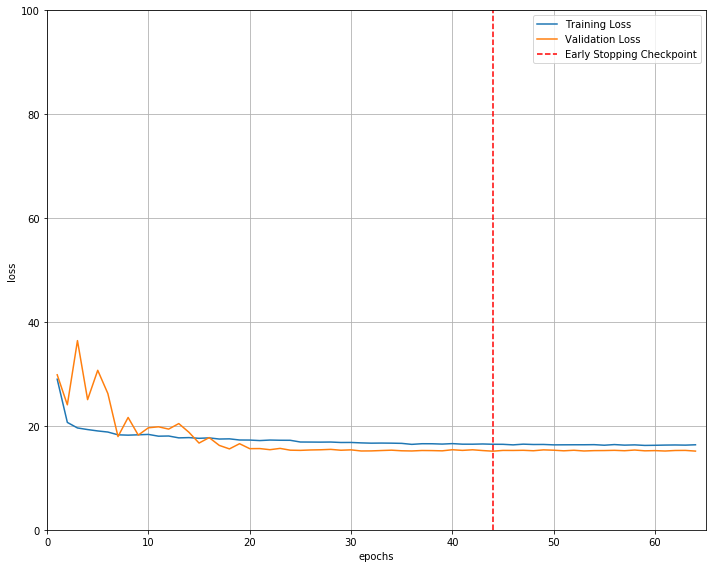

In [8]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 100) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [9]:
def test(net):
    predictions = []
    with torch.no_grad():
        for i, sample in enumerate(testloader):
            x ,y = sample
            x = x.view(-1, 3, IMG_SIZE, IMG_SIZE)
            predict = net(x)
            predict = np.array(predict)
            predictions.append(predict)
            
    #print(predictions)
    predictions = np.array(predictions)
    predictions = predictions.reshape(-1, 5)
    
    df = DataFrame(predictions)
    df.to_excel('predictions.xlsx', header=None)

In [10]:
trained_net = Net()
trained_net.load_state_dict(torch.load(LOAD_PRETRAINED_PATH))
trained_net.eval()
test(trained_net)